In [1]:
import os
import cv2
import numpy as np
import pywt

In [2]:
root_directory = "G:\\DS\\3.Personal_Projects\\Covid_Classification\\Data"

train_data=[] # X_train
test_data=[] # X_test
train_label=[] # y_train
test_label=[] # y_test

img_row,img_col = 32,32

num_of_classes = 2

data_type =["train","test"]
folder_names=["covid_without_PNEUMONIA","covid_with_PNEUMONIA"]
label_mapping={"covid_without_PNEUMONIA":0,"covid_with_PNEUMONIA":1}

In [3]:
def w2d(img, mode='haar', level=1): #skipped
    imArray = img

    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;

    coeffs=pywt.wavedec2(imArray, mode, level=level)


    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

In [4]:
def process_img(dataset,folder,filename): 
    file_path = root_directory+"\\"+dataset+"\\"+folder+"\\"+filename
    img = cv2.imread(file_path)
    scalled_raw_img = cv2.resize(img, (32, 32))
    img_har = w2d(img,'db1',5) #dlt
    scalled_img_har = cv2.resize(img_har, (32, 32)) #dlt 
    combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1))) #dlt 
    return combined_img  #scalled_raw_img

In [5]:
for dataset in data_type:
    for folder in folder_names:
        for filename in os.listdir(root_directory+"\\"+dataset+"\\"+folder+"\\"):
            if dataset == "train":
                train_data.append((process_img(dataset,folder,filename))/255.0) #rescale+resize
                train_label.append(label_mapping[folder])
            else:
                test_data.append((process_img(dataset,folder,filename))/255.0)
                test_label.append(label_mapping[folder])


In [6]:
train_data = np.asarray(train_data)
train_label = np.asarray(train_label)

test_data = np.asarray(test_data)
test_label = np.asarray(test_label)

In [7]:
X_train = train_data
X_test = test_data

y_train = train_label 
y_test = test_label 

In [8]:
X_train = np.array(X_train).reshape(len(X_train),4096).astype(float)
X_test = np.array(X_test).reshape(len(X_test),4096).astype(float) # 4096 is vectorized lenght of an image

In [9]:

import pandas as pd
import pandas_profiling as pp
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [11]:

#itterating to find the best k value
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.95180723, 0.91566265, 0.91566265, 0.93975904, 0.91566265,
       0.92771084, 0.92771084, 0.92771084, 0.92771084])

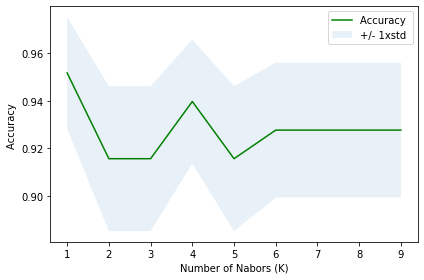

In [12]:

#Plot model accuracy for Different number of Neighbors

plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10) #showing 68% data
plt.legend(('Accuracy ', '+/- 1xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

scores=[]
best_estimators = {}


model_params = {  
    

    'KNeighborsClassifier': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [4,5,6],
            'algorithm' : ['auto','ball_tree','kd_tree'],
            'weights' : ['uniform','distance'],
            'leaf_size' : [27,26,25,24,23,22,21,20,19]
        }
    },
    
    'DecisionTreeClassifier': {
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini','entropy'],
            'max_depth' : [9,10,11,12,13,14]
        }
    },
    
    
    'AdaBoostClassifier': {
        'model': AdaBoostClassifier(),
        'params': {
            'n_estimators': [40,41,42,43],
            'learning_rate' : [0.8],
            'algorithm' : ['SAMME', 'SAMME.R']
        }
    },
    
    'GaussianNB': {
        'model': GaussianNB(),
        'params': {
            
        }
    },
    
     'LOGISTIC_REGRESSION': {
        'model': LogisticRegression(max_iter=500),
        'params': {
            'C': [1,2,3],
            'solver' : [ 'liblinear', 'lbfgs'],
            'multi_class' : ['auto', 'ovr' ]
        }
    },
    
        
    'SVM': {
        'model': SVC(),
        'params': {
             'C': [5,6,7,8,9],
             'kernel': ['rbf','linear'],
             'gamma': ['auto', 'scale']
        }
    },
       
    'RANDOM_FOREST':{
        'model' : RandomForestClassifier(),
        'params': {
            'n_estimators':[12,7,8,9,11,10,13,14,16],
            'criterion': ['entropy'],
            'random_state' : [14,15,13,16],
            'max_depth' : [7,8,6,9]

        }
    }
}

In [13]:
scores=[]
best_estimators = {}


model_params = {  
    

    'KNeighborsClassifier': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [6],
            'algorithm' : ['auto'],
            'weights' : ['distance'],
            'leaf_size' : [27]
        }
    },
    
    'DecisionTreeClassifier': {
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini'],
            'max_depth' : [14]
        }
    },
    
    
    'AdaBoostClassifier': {
        'model': AdaBoostClassifier(),
        'params': {
            'n_estimators': [42],
            'learning_rate' : [0.8],
            'algorithm' : ['SAMME']
        }
    },
    
    'GaussianNB': {
        'model': GaussianNB(),
        'params': {
            
        }
    },
    
     'LOGISTIC_REGRESSION': {
        'model': LogisticRegression(max_iter=500),
        'params': {
            'C': [1],
            'solver' : ['lbfgs'],
            'multi_class' : ['auto']
        }
    },
    
        
    'SVM': {
        'model': SVC(),
        'params': {
             'C': [9],
             'kernel': ['rbf'],
             'gamma': ['auto']
        }
    },
       
    'RANDOM_FOREST':{
        'model' : RandomForestClassifier(),
        'params': {
            'n_estimators':[11],
            'criterion': ['entropy'],
            'random_state' : [13],
            'max_depth' : [6]

        }
    }
}

In [14]:
import time


for model_name, mp in model_params.items():
    clf = GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    print(mp['model'], mp['params'])
    start_time = time.time()
    
    clf.fit(X_train, y_train)    
    

    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': str(clf.best_params_)
    })
    best_estimators[model_name] = clf.best_estimator_
    print('{} minutes'.format((time.time() - start_time)/60))

KNeighborsClassifier() {'n_neighbors': [6], 'algorithm': ['auto'], 'weights': ['distance'], 'leaf_size': [27]}
0.0015514453252156576 minutes
DecisionTreeClassifier() {'criterion': ['gini'], 'max_depth': [14]}
0.04404278596242269 minutes
AdaBoostClassifier() {'n_estimators': [42], 'learning_rate': [0.8], 'algorithm': ['SAMME']}
0.3740949551264445 minutes
GaussianNB() {}
0.002452226479848226 minutes
LogisticRegression(max_iter=500) {'C': [1], 'solver': ['lbfgs'], 'multi_class': ['auto']}
0.012432658672332763 minutes
SVC() {'C': [9], 'kernel': ['rbf'], 'gamma': ['auto']}
0.00895067850748698 minutes
RandomForestClassifier() {'n_estimators': [11], 'criterion': ['entropy'], 'random_state': [13], 'max_depth': [6]}
0.007798206806182861 minutes


In [15]:

import pandas as pd    
df2 = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df2 = df2.sort_values(by='best_score',ascending=False)
df2

,model,best_score,best_params
5,SVM,0.936142,"{'C': 9, 'gamma': 'auto', 'kernel': 'rbf'}"
0,KNeighborsClassifier,0.934017,"{'algorithm': 'auto', 'leaf_size': 27, 'n_neig..."
3,GaussianNB,0.927326,{}
4,LOGISTIC_REGRESSION,0.925079,"{'C': 1, 'multi_class': 'auto', 'solver': 'lbf..."
6,RANDOM_FOREST,0.918437,"{'criterion': 'entropy', 'max_depth': 6, 'n_es..."
2,AdaBoostClassifier,0.907350,"{'algorithm': 'SAMME', 'learning_rate': 0.8, '..."
1,DecisionTreeClassifier,0.843346,"{'criterion': 'gini', 'max_depth': 14}"


In [102]:
df2.to_csv('ml_model.csv', index=False)

In [16]:
cross_val_score(best_estimators['RANDOM_FOREST'],X_test,y_test,cv=5).mean()

0.9625

In [17]:
cross_val_score(best_estimators['RANDOM_FOREST'],X_train,y_train,cv=5).mean()

0.9184371184371185

In [18]:
cross_val_score(best_estimators['SVM'],X_test,y_test,cv=5).mean()

0.9632352941176471

In [19]:
cross_val_score(best_estimators['SVM'],X_train,y_train,cv=5).mean()

0.9361416361416361

In [20]:
cross_val_score(best_estimators['KNeighborsClassifier'],X_test,y_test,cv=5).mean()

0.9632352941176471

In [21]:
best_clf = best_estimators['RANDOM_FOREST']
best_clf

RandomForestClassifier(criterion='entropy', max_depth=6, n_estimators=11,
                       random_state=13)

In [22]:
from sklearn.metrics import classification_report
print(classification_report(y_test,best_clf.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97        39
           1       0.96      1.00      0.98        44

    accuracy                           0.98        83
   macro avg       0.98      0.97      0.98        83
weighted avg       0.98      0.98      0.98        83



In [23]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[37,  2],
       [ 0, 44]], dtype=int64)

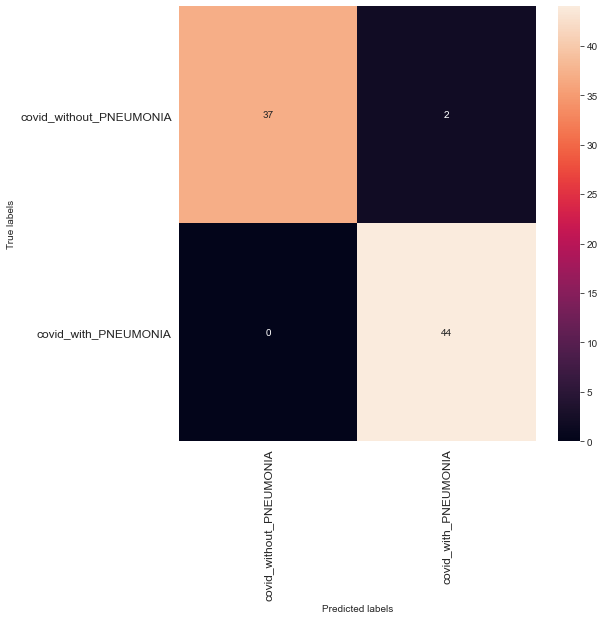

In [26]:
fig, ax = plt.subplots(figsize=(8,8))

g = sns.heatmap(cm,annot=True,ax=ax)
g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 12)
g.set_xticklabels(g.get_xticklabels(), rotation = 90, fontsize = 12)
ax.xaxis.set_ticklabels(label_mapping.keys()); ax.yaxis.set_ticklabels(label_mapping.keys());
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');

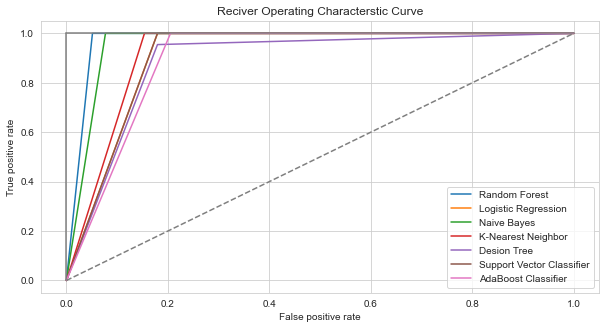

In [25]:

lr_false_positive_rate,lr_true_positive_rate,lr_threshold = metrics.roc_curve(y_test,best_estimators['LOGISTIC_REGRESSION'].predict(X_test))
nb_false_positive_rate,nb_true_positive_rate,nb_threshold = metrics.roc_curve(y_test,best_estimators['GaussianNB'].predict(X_test))
rf_false_positive_rate,rf_true_positive_rate,rf_threshold = metrics.roc_curve(y_test,best_estimators['RANDOM_FOREST'].predict(X_test))                                                             
knn_false_positive_rate,knn_true_positive_rate,knn_threshold = metrics.roc_curve(y_test,best_estimators['KNeighborsClassifier'].predict(X_test))
dt_false_positive_rate,dt_true_positive_rate,dt_threshold = metrics.roc_curve(y_test,best_estimators['DecisionTreeClassifier'].predict(X_test))
svc_false_positive_rate,svc_true_positive_rate,svc_threshold = metrics.roc_curve(y_test,best_estimators['SVM'].predict(X_test))
ada_false_positive_rate,ada_true_positive_rate,ada_threshold = metrics.roc_curve(y_test,best_estimators['AdaBoostClassifier'].predict(X_test))


sns.set_style('whitegrid')
plt.figure(figsize=(10,5))
plt.title('Reciver Operating Characterstic Curve')

plt.plot(rf_false_positive_rate,rf_true_positive_rate,label='Random Forest')
plt.plot(lr_false_positive_rate,lr_true_positive_rate,label='Logistic Regression')
plt.plot(nb_false_positive_rate,nb_true_positive_rate,label='Naive Bayes')
plt.plot(knn_false_positive_rate,knn_true_positive_rate,label='K-Nearest Neighbor')
plt.plot(dt_false_positive_rate,dt_true_positive_rate,label='Desion Tree')
plt.plot(svc_false_positive_rate,svc_true_positive_rate,label='Support Vector Classifier')
plt.plot(ada_false_positive_rate,ada_true_positive_rate,label='AdaBoost Classifier')
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.legend()
plt.show()

In [52]:
import joblib 
joblib.dump(best_clf, 'xray_model.pkl')

['xray_model.pkl']

In [53]:
import json
with open("xray_class_dictionary.json","w") as f:
    f.write(json.dumps(label_mapping))

In [68]:
import matplotlib.pyplot as plt
cwthpneu = cv2.imread('G:\\DS\\3.Personal_Projects\\Covid_Classification\\Data\\test\\covid_with_PNEUMONIA\\person33_virus_72.jpeg')
cwthoutpneu = cv2.imread('G:\\DS\\3.Personal_Projects\\Covid_Classification\\Data\\test\\covid_without_PNEUMONIA\\446B2CB6-B572-40AB-B01F-1910CA07086A.jpeg')

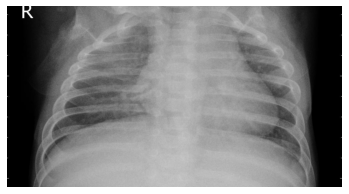

In [64]:
plt.imshow(cwthpneu)
plt.axis('off')
plt.show()

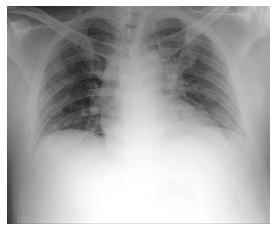

In [65]:
plt.imshow(cwthoutpneu)
plt.axis('off')
plt.show()

In [66]:
def process_img_for_pred(img): 
    scalled_raw_img = cv2.resize(img, (32, 32))
    img_har = w2d(img,'db1',5)
    scalled_img_har = cv2.resize(img_har, (32, 32))
    combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
    return combined_img 

In [91]:
cwthpneu_arr = process_img_for_pred(cwthpneu)/255
cwthoutpneu_arr = process_img_for_pred(cwthoutpneu)/255

In [96]:
def get_key(val):
    for key, value in label_mapping.items():
         if val == value:
             return key
 
    return "key doesn't exist"

In [99]:
get_key(best_clf.predict(cwthpneu_arr.reshape(1,-1))[0])

'covid_with_PNEUMONIA'

In [100]:
get_key(best_clf.predict(cwthoutpneu_arr.reshape(1,-1))[0])

'covid_without_PNEUMONIA'